In [1]:
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib
import keras
import numpy as np
import matplotlib.pyplot as plt
import time


Using TensorFlow backend.


Time for GBR fitting: 1.077
Mean Squared Error for Gradient Boosting: 1.651040384149584e-05


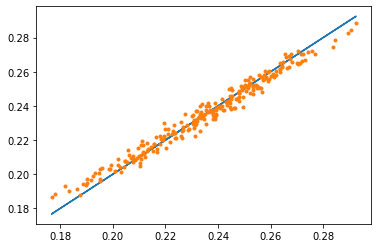

In [2]:
# Train Optimizer function approximator from disturbance to optimal input
# Import training data 
df = pd.read_csv('case4a_data1.csv') # measurement data set does not matter here, since this part is feedforward

dataset = df.values

D = dataset[:,0:8]
U = dataset[:,8]
U1 = D.reshape(-1, 1)


# Split data into traning and validation sets
from sklearn.model_selection import train_test_split
D_train, D_val, U_train, U_val = train_test_split(D, U, test_size=0.25)

# Fit Gradient Boosting 
from sklearn.ensemble import GradientBoostingRegressor

gbOpt = GradientBoostingRegressor(n_estimators=1000)

stime = time.time()
gbOpt.fit(D_train, U_train)
print("Time for GBR fitting: %.3f" % (time.time() - stime))

D_pred_gb = gbOpt.predict(D_val)
mae = np.mean(abs(D_pred_gb - U_val))
mse = np.mean((D_pred_gb - U_val)**2)
print('Mean Squared Error for Gradient Boosting:', mse)

plt.plot(U_val,U_val)
plt.plot(U_val,D_pred_gb,'.')

(749, 5) (250, 5) (749, 8) (250, 8)
Time for GBR fitting: 2.463
Mean Squared Error for Gradient Boosting: 11.82380802799572
(250, 8)


Text(0.5, 1.0, 'UA2')

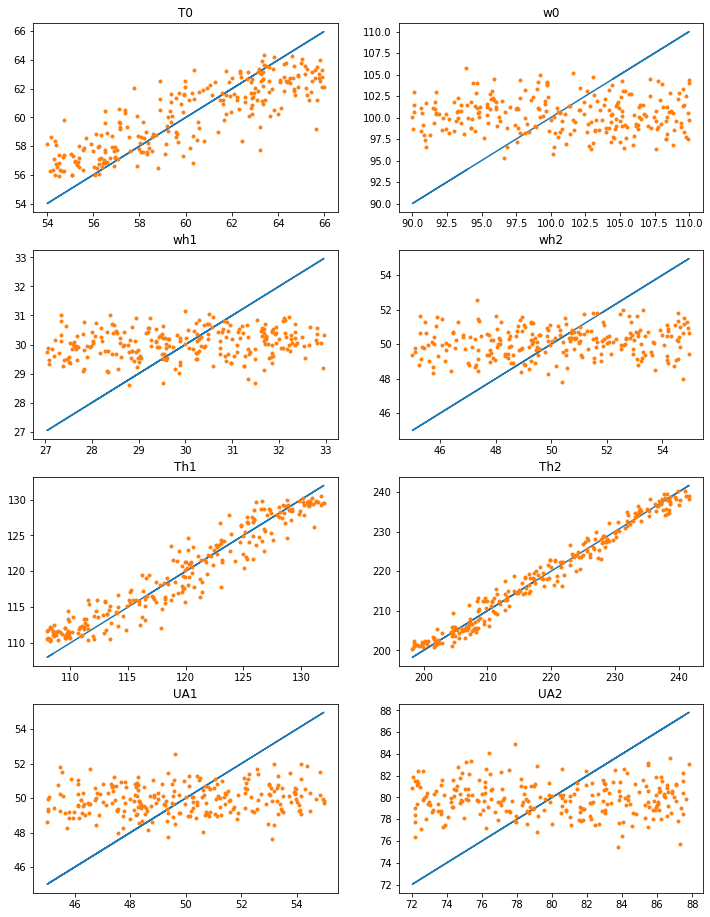

In [3]:
# Train Estimator function approximator from measurements to disturbances
# Import training data 
df = pd.read_csv('case4b_data2.csv') # Measurement data set affects this part.

dataset = df.values

Y = dataset[:,0:5]
D = dataset[:,5:13]

Y_train, Y_val, D_train, D_val = train_test_split(Y, D, test_size=0.25)
print(Y_train.shape, Y_val.shape, D_train.shape, D_val.shape)

# Fit Gradient Boosting 
from sklearn.ensemble import RandomForestRegressor
gbEst = RandomForestRegressor(n_estimators=1000)

stime = time.time()
gbEst.fit(Y_train, D_train)
print("Time for GBR fitting: %.3f" % (time.time() - stime))

D_pred_gb = gbEst.predict(Y_val)
mae = np.mean(abs(D_pred_gb - D_val))
mse = np.mean((D_pred_gb - D_val)**2)
print('Mean Squared Error for Gradient Boosting:', mse)

print(D_val.shape)
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4, ncols=2,
                                      sharex=False, figsize=(12, 16))


ax1.plot(D_val[:,0],D_val[:,0])
ax1.plot(D_val[:,0],D_pred_gb[:,0],'.')
ax1.set_title('T0')


ax2.plot(D_val[:,1],D_val[:,1])
ax2.plot(D_val[:,1],D_pred_gb[:,1],'.')
ax2.set_title('w0')


ax3.plot(D_val[:,2],D_val[:,2])
ax3.plot(D_val[:,2],D_pred_gb[:,2],'.')
ax3.set_title('wh1')


ax4.plot(D_val[:,3],D_val[:,3])
ax4.plot(D_val[:,3],D_pred_gb[:,3],'.')
ax4.set_title('wh2')


ax5.plot(D_val[:,4],D_val[:,4])
ax5.plot(D_val[:,4],D_pred_gb[:,4],'.')
ax5.set_title('Th1')


ax6.plot(D_val[:,5],D_val[:,5])
ax6.plot(D_val[:,5],D_pred_gb[:,5],'.')
ax6.set_title('Th2')


ax7.plot(D_val[:,6],D_val[:,6])
ax7.plot(D_val[:,6],D_pred_gb[:,6],'.')
ax7.set_title('UA1')


ax8.plot(D_val[:,7],D_val[:,7])
ax8.plot(D_val[:,7],D_pred_gb[:,7],'.')
ax8.set_title('UA2')

In [4]:
# ------------ Closed-loop testing starts here ! --------------
# import and initialize model 
import Model as model

df = pd.read_csv('case4a_Testdata2.csv')
dataset = df.values

X_test = dataset[:,0:8]
Y_test = dataset[:,8]
bias =  dataset[:,9:14]
dist = dataset[:,14:22]
Jopt = dataset[:,22]
uopt = dataset[:,23]

print(dataset.shape)

(999, 24)


In [5]:
J = []
U = []
Ju = []

for i in range(999):
    class parameters():
        T0=dist[i,0]    
        w0=dist[i,1]    
        wh1=dist[i,2]  
        wh2=dist[i,3]  
        Th1=dist[i,4]  
        Th2=dist[i,5]  
        UA1=dist[i,6]  
        UA2=dist[i,7]  
    
    par = parameters()

    # initial operating point
    u = 0.5
    meas = model.hex_output(u,par)
    y = [np.array([meas[0],meas[2],meas[4],meas[5],meas[6]])]

    for j in range(10):
        d = gbEst.predict(y)
        u = gbOpt.predict(d)
        meas = model.hex_output(u,par)
        y = [np.array([meas[0],meas[2],meas[4],meas[5],meas[6]]  + bias[i,:])]
        
    # save the converged values of cost, input and gradient   
    J.append(meas[7])
    U.append(u)

-0.007111759390426187


Text(0.5, 1.0, 'Input u')

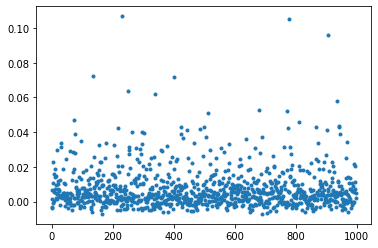

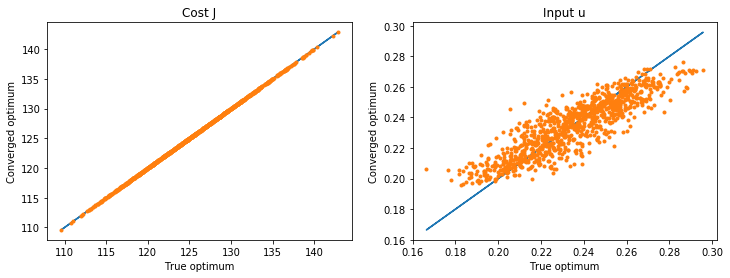

In [6]:
# plot results 
J_cl = np.array(J)
J_cl = J_cl.reshape(999,)

Jopt = np.array(Jopt)
Jopt = Jopt.reshape(999,)

plt.plot(-Jopt-J_cl,'.')
print(min(-Jopt-J_cl))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                       sharex=False, figsize=(12, 4))

ax1.plot(-Jopt,-Jopt)
ax1.plot(-Jopt,J,'.')
ax1.set_xlabel('True optimum')
ax1.set_ylabel('Converged optimum')
ax1.set_title('Cost J')

ax2.plot(uopt,uopt)
ax2.plot(uopt,U,'.')
ax2.set_xlabel('True optimum')
ax2.set_ylabel('Converged optimum')
ax2.set_title('Input u')